# Исследовательский анализ данных (EDA)
## Анализ лекарственной активности химических соединений

In [69]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('default')
sns.set_palette("husl")

In [70]:
# Загрузка данных
!pip install openpyxl

# Клонирование репозитория
!git clone https://github.com/schwarzRabe/drug_activity_prediction.git

# Переход в папку и загрузка данных
import pandas as pd
import os

os.chdir('drug_activity_prediction')
df = pd.read_excel('data/chemi_data.xlsx')
print("Данные загружены успешно!")
print(f"Размер данных: {df.shape}")

Cloning into 'drug_activity_prediction'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 25 (delta 5), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 1.63 MiB | 8.71 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Данные загружены успешно!
Размер данных: (1001, 214)


In [71]:
print("ОСНОВНАЯ ИНФОРМАЦИЯ")
print(f"Размер датасета: {df.shape}")
print(f"Количество признаков: {df.shape[1]}")
print(f"Количество образцов: {df.shape[0]}")

ОСНОВНАЯ ИНФОРМАЦИЯ
Размер датасета: (1001, 214)
Количество признаков: 214
Количество образцов: 1001


In [72]:
# Типы данных
df.dtypes.value_counts()

,count
int64,107
float64,107


In [73]:
df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# Пропущенные значения
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_data.head(15)

,0
Unnamed: 0,0
"IC50, mM",0
"CC50, mM",0
SI,0
MaxAbsEStateIndex,0
MaxEStateIndex,0
MinAbsEStateIndex,0
MinEStateIndex,0
qed,0
SPS,0


In [75]:
# Удаление всех строк с хотя бы одним пропущенным значением
df_cleaned = df.dropna()

# Проверка результата
print(f"Первоначальна форма: {df.shape}")
print(f"Форма после удаления пропущенных данных: {df_cleaned.shape}")

Первоначальна форма: (1001, 214)
Форма после удаления пропущенных данных: (998, 214)


Анализ целевых переменных IC50, CC50, SI

In [76]:
target_cols = ['IC50, mM', 'CC50, mM', 'SI']

In [77]:
# Описательная статистика целевых переменных IC50, CC50, SI
df_cleaned[target_cols].describe()

,"IC50, mM","CC50, mM",SI
count,998.000000,998.000000,998.000000
mean,221.118757,586.668414,72.650005
std,400.510657,642.016454,685.504279
min,0.003517,0.700808,0.011489
25%,12.491340,99.999036,1.457233
50%,45.992006,408.793314,3.856410
75%,224.408630,891.770961,16.525000
max,4128.529377,4538.976189,15620.600000


In [78]:
    # Взаимосвязь переменных SI, CC50 и IC50

    calculated_si = df_cleaned['CC50, mM'] / df['IC50, mM']
    correlation = df_cleaned['SI'].corr(calculated_si)
    print(f"Корреляция между SI и CC50/IC50: {correlation:.6f}")

    # Различия между SI и вычисленным SI
    diff = np.abs(df_cleaned['SI'] - calculated_si)
    print(f"Среднее абсолютное отклонение: {diff.mean():.6f}")
    print(f"Максимальное отклонение: {diff.max():.6f}")
    print()

Корреляция между SI и CC50/IC50: 1.000000
Среднее абсолютное отклонение: 0.000000
Максимальное отклонение: 0.000000



Для целевых переменны датасета выполняется соотношение IS = CC50 / IC50

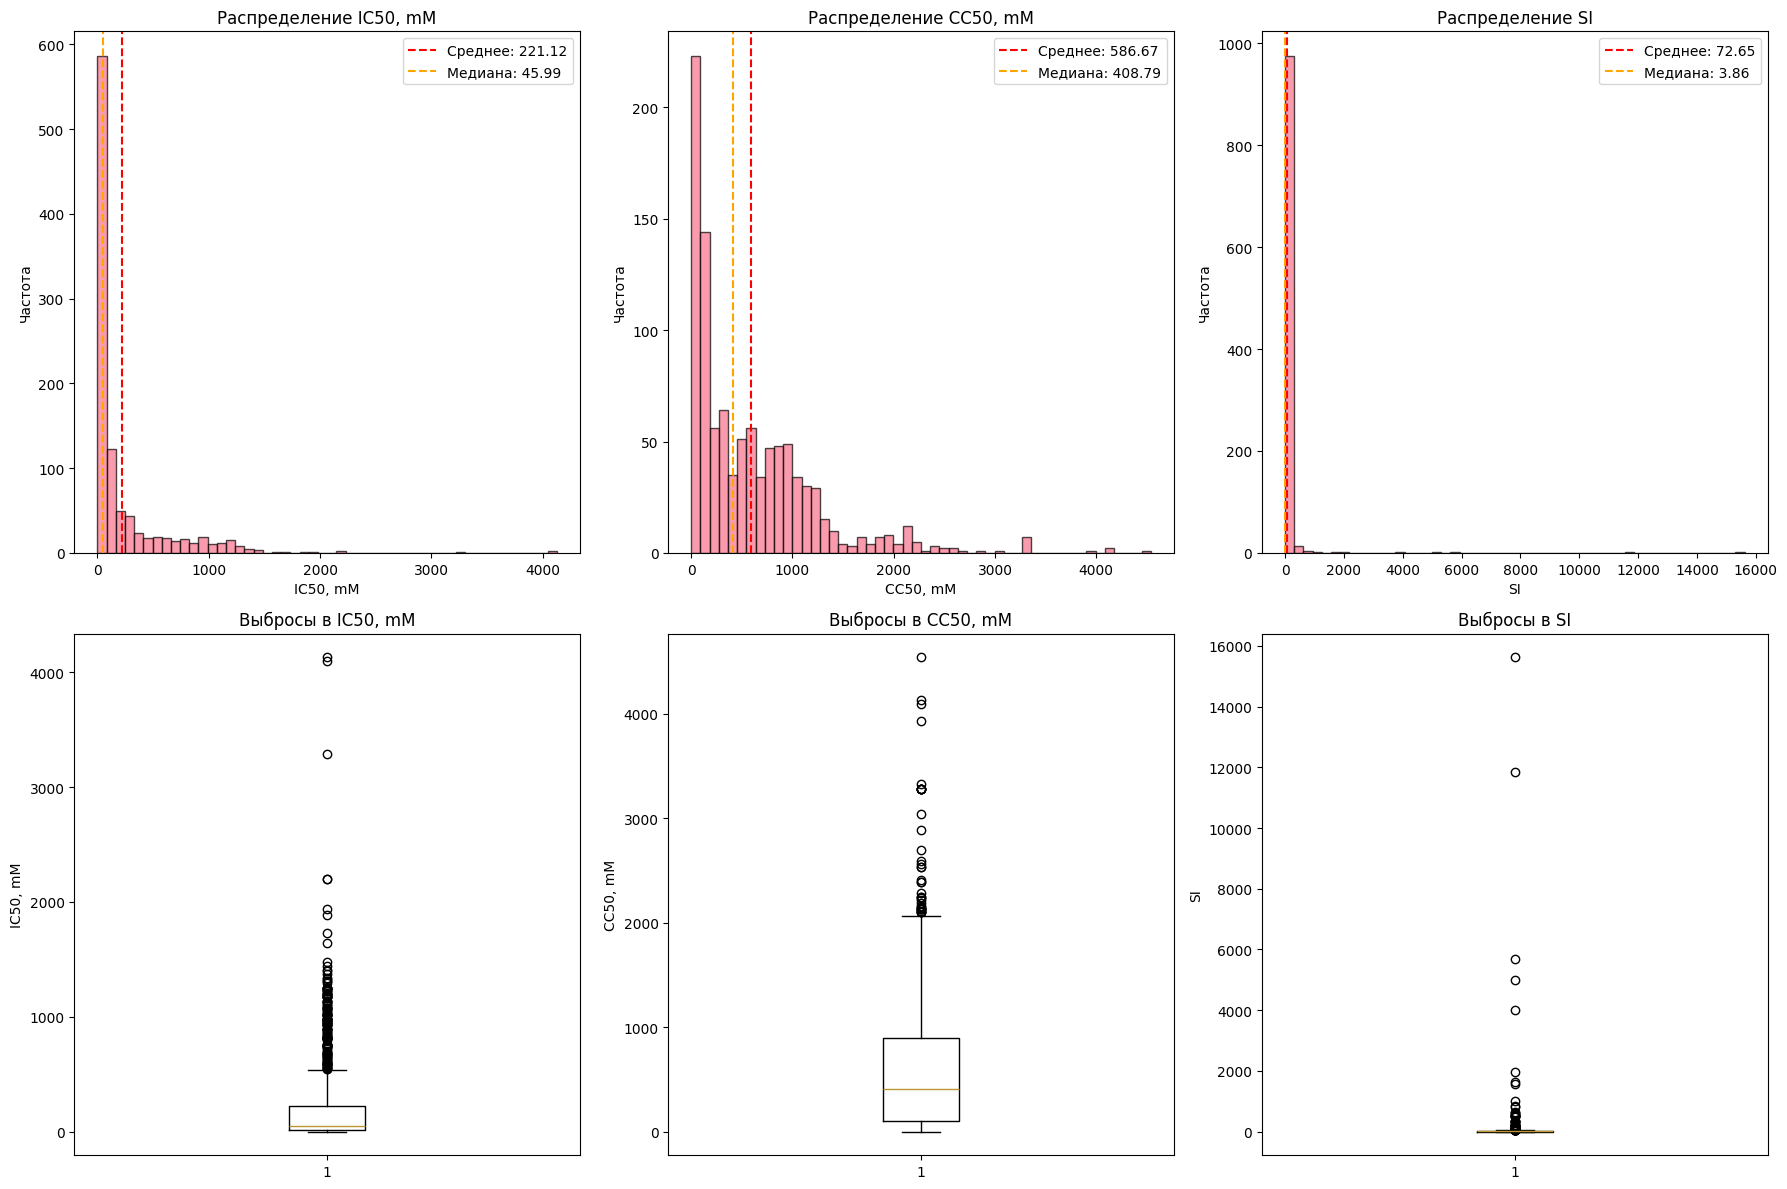

In [79]:
# Визуализация распределений
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, col in enumerate(target_cols):
    # Гистограммы
    axes[0, i].hist(df[col], bins=50, alpha=0.7, edgecolor='black')
    axes[0, i].axvline(df[col].mean(), color='red', linestyle='--', label=f'Среднее: {df_cleaned[col].mean():.2f}')
    axes[0, i].axvline(df[col].median(), color='orange', linestyle='--', label=f'Медиана: {df_cleaned[col].median():.2f}')
    axes[0, i].set_title(f'Распределение {col}')
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel('Частота')
    axes[0, i].legend()

    # Boxplots
    axes[1, i].boxplot(df[col])
    axes[1, i].set_title(f'Выбросы в {col}')
    axes[1, i].set_ylabel(col)

plt.tight_layout()
plt.show()

Анализ выбросов данных

In [80]:
def outlier_analysis(df, target_cols):
    """Анализ выбросов в целевых переменных"""

    for target in target_cols:
        Q1 = df[target].quantile(0.25)
        Q3 = df[target].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[target] < lower_bound) | (df[target] > upper_bound)]

        print(f"\n{target}:")
        print(f"  Q1: {Q1:.3f}, Q3: {Q3:.3f}, IQR: {IQR:.3f}")
        print(f"  Границы выбросов: [{lower_bound:.3f}, {upper_bound:.3f}]")
        print(f"  Количество выбросов: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
        print(f"  Максимальное значение: {df[target].max():.3f}")
        print(f"  Минимальное значение: {df[target].min():.3f}")

outlier_analysis(df_cleaned, target_cols)


IC50, mM:
  Q1: 12.491, Q3: 224.409, IQR: 211.917
  Границы выбросов: [-305.385, 542.285]
  Количество выбросов: 145 (14.5%)
  Максимальное значение: 4128.529
  Минимальное значение: 0.004

CC50, mM:
  Q1: 99.999, Q3: 891.771, IQR: 791.772
  Границы выбросов: [-1087.659, 2079.429]
  Количество выбросов: 39 (3.9%)
  Максимальное значение: 4538.976
  Минимальное значение: 0.701

SI:
  Q1: 1.457, Q3: 16.525, IQR: 15.068
  Границы выбросов: [-21.144, 39.127]
  Количество выбросов: 124 (12.4%)
  Максимальное значение: 15620.600
  Минимальное значение: 0.011


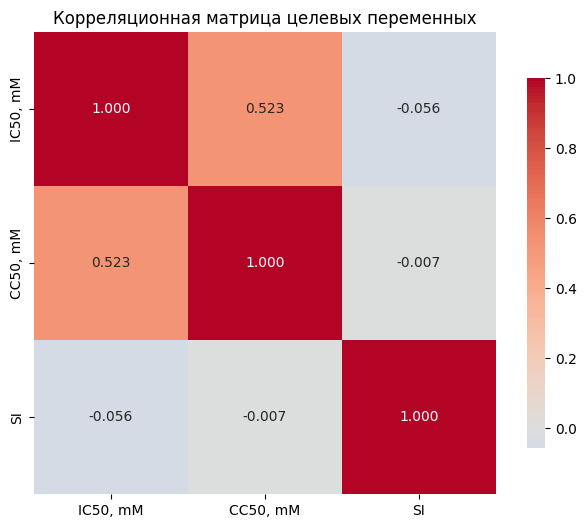

In [81]:
# Корреляционная матрица целевых переменных
correlation_matrix = df_cleaned[target_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Корреляционная матрица целевых переменных')
plt.show()

Анализ признаков

Вариативность признаков - диапазон изменений признака, что поможет исключить константы и почти стабильные признаки. Если некоторые компоненты или характеристики химических соединений практически не меняются, то это не поможет нам найти различия в целевых переменных (хотя возможна, например,ситуация, когда химическое вещество работает как катализатор)



Общее количество признаков: 211
Числовые признаки: 211
Признаки с нулевой вариативностью: 18
Признаки с низкой вариативностью: 0
Признаки с низкой информативностью: ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_thiocyan']


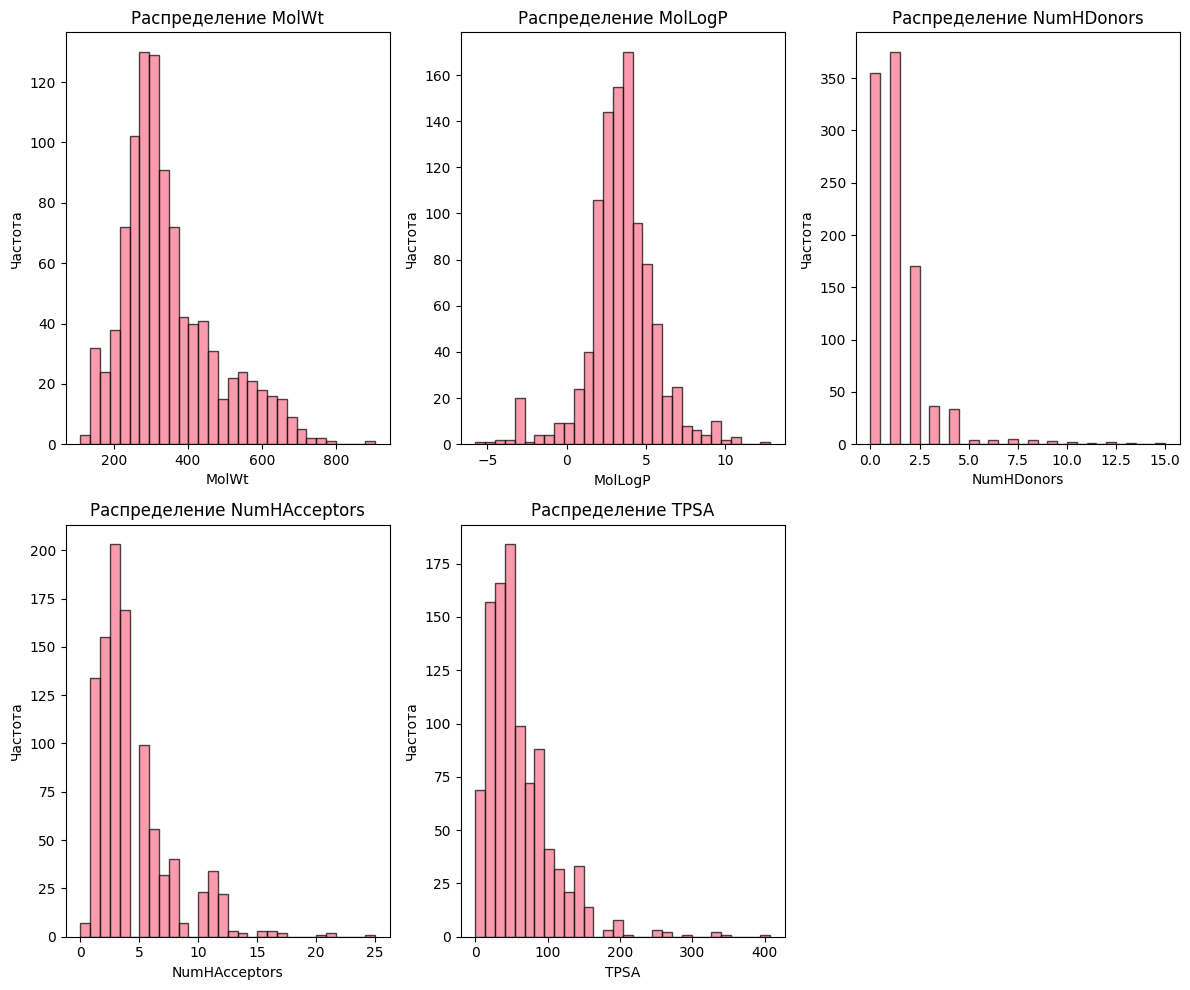

In [82]:
def analyze_features(df, target_cols):

    # Отделяем признаки от целевых переменных
    feature_cols = [col for col in df.columns if col not in target_cols]
    print(f"Общее количество признаков: {len(feature_cols)}")

    # Типы признаков
    numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
    print(f"Числовые признаки: {len(numeric_features)}")

    # Признаки с нулевой вариативностью
    zero_var_features = []
    for col in numeric_features:
        if df[col].std() == 0:
            zero_var_features.append(col)
    print(f"Признаки с нулевой вариативностью: {len(zero_var_features)}")

    # Признаки с низкой вариативностью
    low_var_features = []
    for col in numeric_features:
        if 0 < df[col].std() < 0.01:
            low_var_features.append(col)
    print(f"Признаки с низкой вариативностью: {len(low_var_features)}")

    # Объединённый список "малополезных" признаков
    low_info_features = zero_var_features + low_var_features
    print(f"Признаки с низкой информативностью:", low_info_features)


    # Распределение значений некоторых признаков
    key_features = ['MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']
    available_key_features = [f for f in key_features if f in df.columns]

    if available_key_features:
        fig, axes = plt.subplots(2, 3, figsize=(12, 10))
        axes = axes.flatten()

        for i, feature in enumerate(available_key_features[:6]):
            if i < 6:
                axes[i].hist(df[feature], bins=30, alpha=0.7, edgecolor='black')
                axes[i].set_title(f'Распределение {feature}')
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Частота')

        # Скрываем неиспользуемые подграфики
        for i in range(len(available_key_features), 6):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.show()

    return feature_cols, numeric_features

feature_cols, numeric_features = analyze_features(df_cleaned, target_cols)

Признаки, взятые для примера, имеют асимметричное распределение, чаще всего со сдвигом право, что видно из приведенных гарфиков.

Для примера взяты такие признаки:

MolWt	Молекулярная масса (Molecular Weight) - Слишком большие молекулы хуже проникают через клеточные мембраны и плохо абсорбируются

MolLogP	 - Логарифм распределения между октанолом и водой (гидрофобность) - растворимость и проницаемость вещества.

NumHDonors	Количество доноров водородных связей и NumHAcceptors	Количество акцепторов водородных связей влияют на биодоступность вещества

TPSA	Полярная поверхность (Topological Polar Surface Area) - Связана с способностью к абсорбции и проникновению через биомембраны (включая гематоэнцефалический барьер)

Вывод: Из-за асимметричного распределения и наличия выбросов рекомендуется использовать модели, устойчивые к шуму и выбросам (например, градиентный бустинг, деревья решений) и применять масштабирование и/или преобразование признаков ( логарифмирование)



Кореляционный анализ


Топ-10 признаков, наиболее коррелирующих с IC50, mM:
VSA_EState4     0.271743
Chi2n           0.252705
PEOE_VSA7       0.250772
fr_Ar_NH        0.247728
fr_Nhpyrrole    0.247728
Chi2v           0.246602
Chi4v           0.240485
Chi4n           0.239209
Chi3n           0.235491
Chi3v           0.234816
dtype: float64

Топ-10 признаков, наиболее коррелирующих с CC50, mM:
LabuteASA         0.307774
MolMR             0.307252
MolWt             0.304940
ExactMolWt        0.304883
HeavyAtomCount    0.303065
Chi0              0.302859
Chi1              0.302238
HeavyAtomMolWt    0.302112
Kappa1            0.300393
Chi1v             0.299828
dtype: float64

Топ-10 признаков, наиболее коррелирующих с SI:
BalabanJ            0.164715
fr_NH2              0.160428
RingCount           0.124835
fr_Al_COO           0.102374
fr_COO2             0.101075
fr_COO              0.101075
NumAromaticRings    0.088006
FpDensityMorgan1    0.087894
VSA_EState4         0.087770
VSA_EState6         0.083298
dtyp

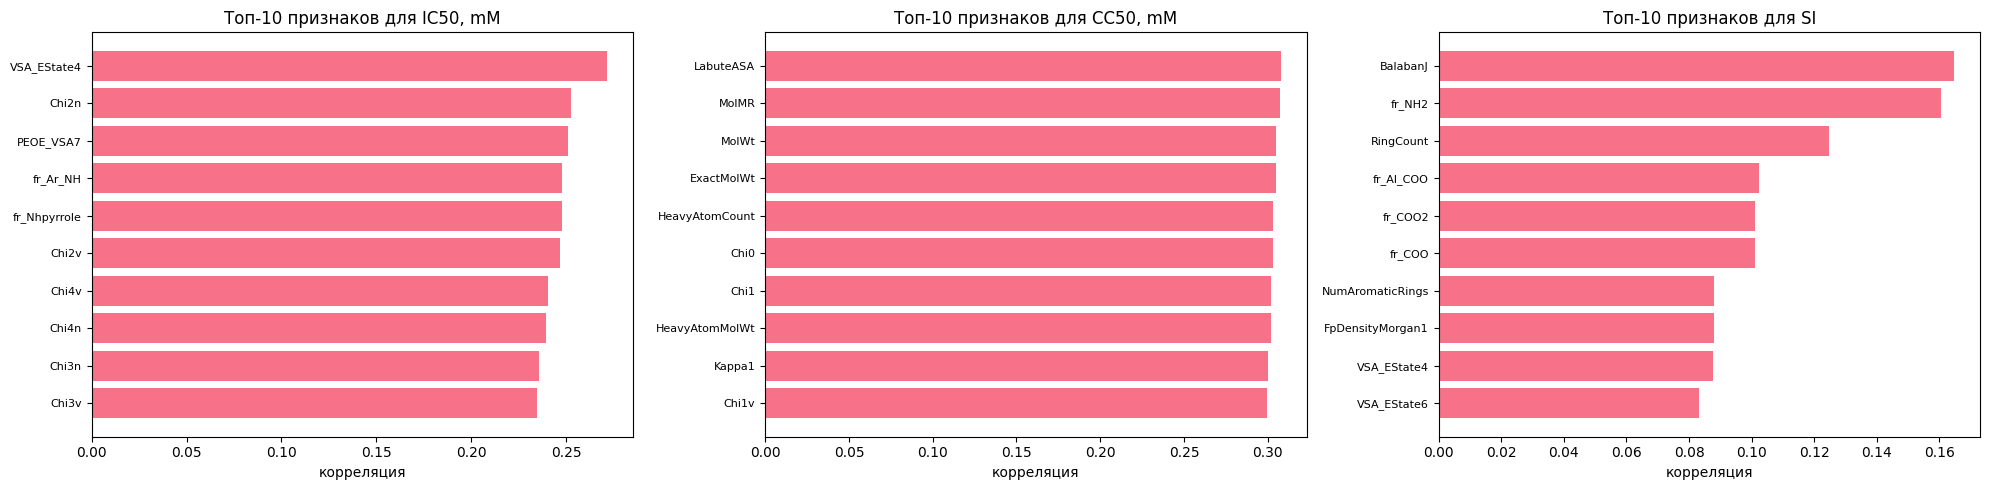

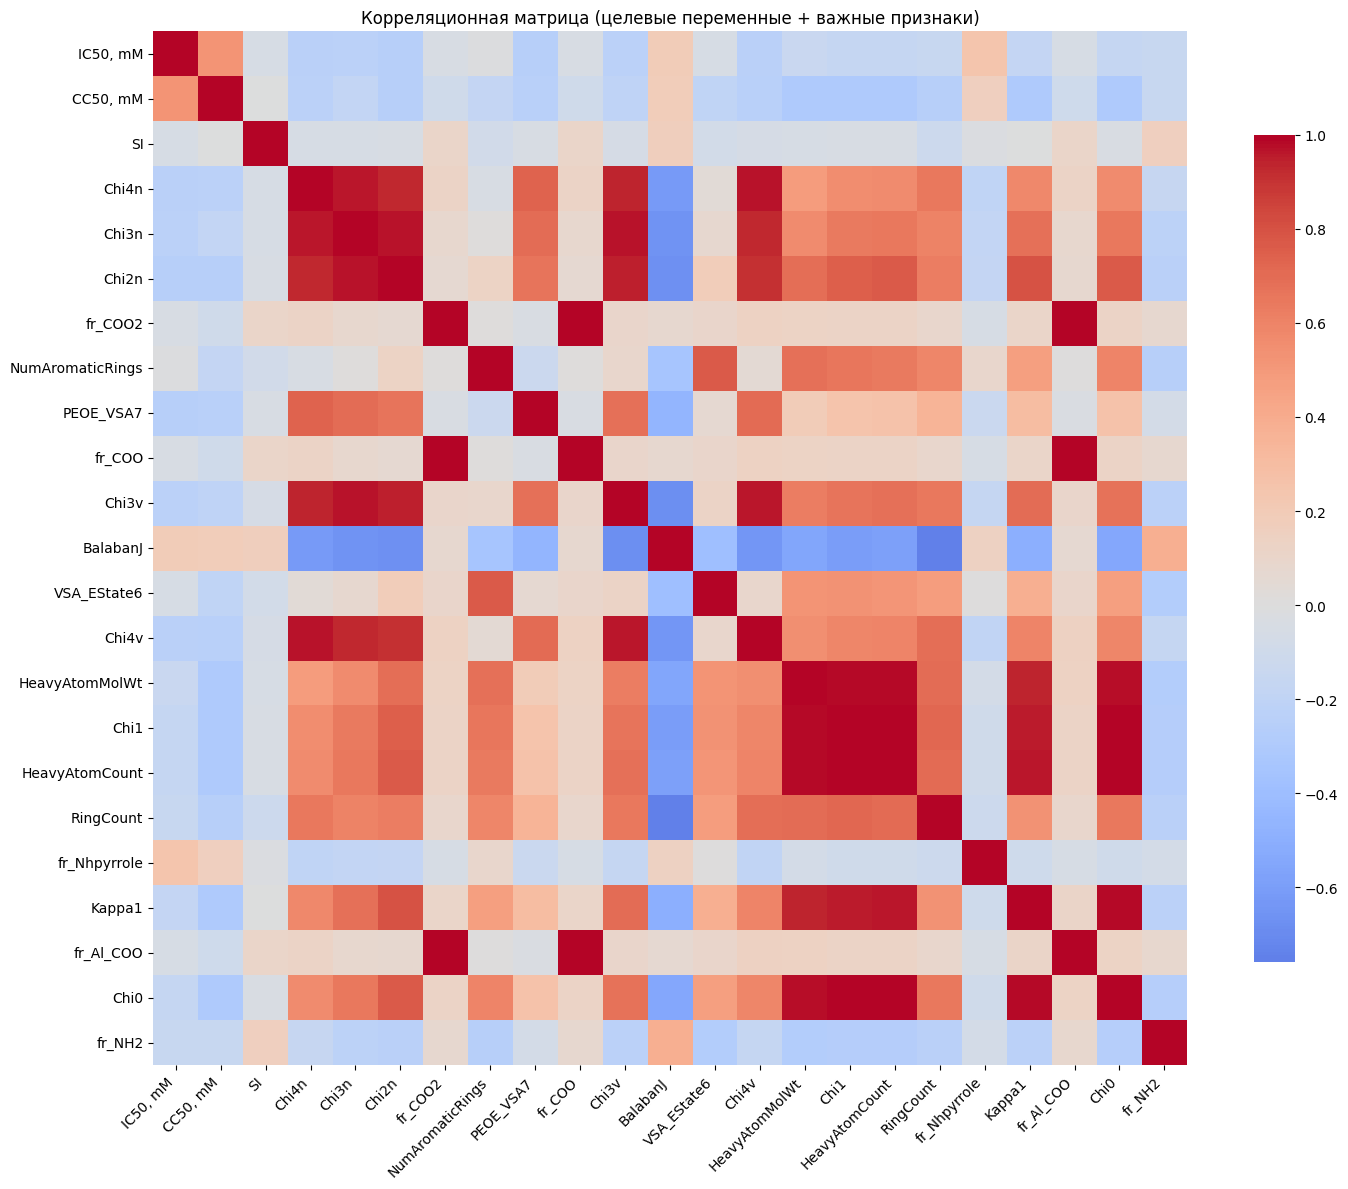

In [83]:
def correlation_analysis(df, target_cols, numeric_features):

    # Корреляция признаков с целевыми переменными
    correlations = {}

    for target in target_cols:
        corr_with_target = df[numeric_features].corrwith(df[target]).abs().sort_values(ascending=False)
        correlations[target] = corr_with_target

        print(f"\nТоп-10 признаков, наиболее коррелирующих с {target}:")
        print(corr_with_target.head(10))

    # Визуализация топ корреляций
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    for i, target in enumerate(target_cols):
        top_features = correlations[target].head(10)

        axes[i].barh(range(len(top_features)), top_features.values)
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features.index, fontsize=8)
        axes[i].set_xlabel('корреляция')
        axes[i].set_title(f'Топ-10 признаков для {target}')
        axes[i].invert_yaxis()

    plt.tight_layout()
    plt.show()

    # Корреляционная матрица между целевыми переменными и топ-признаками
    all_important_features = set()
    for target in target_cols:
        top_10 = correlations[target].head(10).index.tolist()
        all_important_features.update(top_10)

    important_features = list(all_important_features)[:20]  # Ограничиваем до 20 для читаемости

    correlation_subset = df[target_cols + important_features].corr()

    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_subset, annot=False, cmap='coolwarm', center=0,
                square=True, cbar_kws={'shrink': 0.8})
    plt.title('Корреляционная матрица (целевые переменные + важные признаки)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

correlation_analysis(df_cleaned, target_cols, numeric_features)

Отбор признаков для каждой целевой переменной:

1. предварительно фильтруем датасет: убераем признгаки с нулевой и низкой вариативностью и низкой корреляцией с целевой переменной

2. Удалим мультиколлинеарные признаки

3. Отберем признаки с помощью модели Random Forest, т.к. у нас реальные данные в которых линейные завасимости скорее исключение, чем правило. Будем исходить из предположения, что зависимости нелинейные

На выходе получим датасет для каждой из 3-х целевыз переменных с отобранными признаками

In [84]:
def select_features(df, target_cols, min_corr_dict, max_collinear_corr=0.9, top_n=None):
    """
    Для каждой целевой переменной:
        1. Отбирает признаки по вариативности, корреляции, коллинеарности, важности (RandomForest)
        2. Формирует отдельный датафрейм
        3. Сохраняет его в .csv файл

    Аргументы:
        df: DataFrame
        target_cols: list[str] — список целевых переменных (например: ['IC50', 'CC50', 'SI'])
        min_corr_dict: минимальная допустимая корреляция с target
        max_collinear_corr: float — максимально допустимая взаимная корреляция между признаками
        top_n: int — сколько признаков сохраняем
    """
    for target in target_cols:
        print(f"\n{target}")

        # Выбираем все признаки, исключая целевую переменную
        features = [col for col in df.select_dtypes(include=np.number).columns if col != target and col not in target_cols]


        # Удалим признаки с нулевой и низкой вариативностью
        zero_var_features = [col for col in features if df[col].std() == 0]
        low_var_features = [col for col in features if 0 < df[col].std() < 0.01]
        low_info_features = zero_var_features + low_var_features
        features = [col for col in features if col not in low_info_features]

        # Фильтр по корреляции с целевой переменной
        min_corr = min_corr_dict.get(target)
        corr = df[features].corrwith(df[target]).abs()
        features = corr[corr >= min_corr].index.tolist()

        # Удаление мультиколлинеарных признаков
        corr_matrix = df[features].corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > max_collinear_corr)]
        features = [col for col in features if col not in to_drop]

        # RandomForest
        X = df[features]
        y = df[target]
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        importances = pd.Series(rf.feature_importances_, index=X.columns)

        # Отбираем признаки: если количество жестко не задано - берем все
        if top_n is not None:
            top_features = importances.sort_values(ascending=False).head(top_n)
        else:
            top_features = importances[importances > 0].sort_values(ascending=False)

        # Сохраняем результат
        final_df = df[top_features.index.tolist() + [target]]
        filename = f"selected_features_{target}.csv"
        final_df.to_csv(filename, index=False)

        print(f"Отобрано признаков: {len(top_features)-1}")
        print(f"Сохранено в файл: {filename}")

In [85]:
# выбираем 25 признаков на каждую переменную
# переменная target_cols = ['IC50, mM', 'CC50, mM', 'SI'] - определена выше
# для каждой целевой переменной берем разных минимальный порог корреляции
min_corrs = {
    'IC50, mM': 0.1,
    'CC50, mM': 0.15,
    'SI': 0.05
}

select_features(df_cleaned, target_cols=['IC50, mM', 'CC50, mM', 'SI'], min_corr_dict=min_corrs, top_n=25)


IC50, mM
Отобрано признаков: 24
Сохранено в файл: selected_features_IC50, mM.csv

CC50, mM
Отобрано признаков: 24
Сохранено в файл: selected_features_CC50, mM.csv

SI
Отобрано признаков: 24
Сохранено в файл: selected_features_SI.csv


In [86]:
os.rename("selected_features_IC50, mM.csv", "selected_features_IC50_mM.csv")
os.rename("selected_features_CC50, mM.csv", "selected_features_CC50_mM.csv")

In [87]:
df_IC50 = pd.read_csv('selected_features_IC50_mM.csv')
df_CC50 = pd.read_csv('selected_features_CC50_mM.csv')
df_SI = pd.read_csv('selected_features_SI.csv')

In [88]:
df_IC50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BCUT2D_MWLOW              998 non-null    float64
 1   MolWt                     998 non-null    float64
 2   VSA_EState4               998 non-null    float64
 3   BCUT2D_LOGPHI             998 non-null    float64
 4   qed                       998 non-null    float64
 5   PEOE_VSA7                 998 non-null    float64
 6   VSA_EState8               998 non-null    float64
 7   FpDensityMorgan1          998 non-null    float64
 8   MaxAbsEStateIndex         998 non-null    float64
 9   BalabanJ                  998 non-null    float64
 10  EState_VSA5               998 non-null    float64
 11  MaxPartialCharge          998 non-null    float64
 12  MinEStateIndex            998 non-null    float64
 13  MolLogP                   998 non-null    float64
 14  SlogP_VSA5

In [89]:
df_CC50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         998 non-null    int64  
 1   MolWt              998 non-null    float64
 2   FpDensityMorgan1   998 non-null    float64
 3   PEOE_VSA7          998 non-null    float64
 4   BCUT2D_CHGLO       998 non-null    float64
 5   VSA_EState4        998 non-null    float64
 6   MinPartialCharge   998 non-null    float64
 7   BalabanJ           998 non-null    float64
 8   MolLogP            998 non-null    float64
 9   TPSA               998 non-null    float64
 10  PEOE_VSA6          998 non-null    float64
 11  EState_VSA4        998 non-null    float64
 12  BCUT2D_LOGPLOW     998 non-null    float64
 13  FractionCSP3       998 non-null    float64
 14  SMR_VSA7           998 non-null    float64
 15  NumRotatableBonds  998 non-null    int64  
 16  SMR_VSA10          998 non

In [90]:
df_SI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BalabanJ                  998 non-null    float64
 1   MinAbsEStateIndex         998 non-null    float64
 2   BCUT2D_LOGPHI             998 non-null    float64
 3   SMR_VSA5                  998 non-null    float64
 4   VSA_EState4               998 non-null    float64
 5   MinPartialCharge          998 non-null    float64
 6   EState_VSA2               998 non-null    float64
 7   BCUT2D_LOGPLOW            998 non-null    float64
 8   MinAbsPartialCharge       998 non-null    float64
 9   Kappa3                    998 non-null    float64
 10  SlogP_VSA3                998 non-null    float64
 11  AvgIpc                    998 non-null    float64
 12  Chi3n                     998 non-null    float64
 13  RingCount                 998 non-null    int64  
 14  BertzCT   

In [91]:
import os
for f in os.listdir():
    if f.endswith('.csv'):
        print(f)

selected_features_SI.csv
selected_features_IC50_mM.csv
selected_features_CC50_mM.csv


In [92]:
import IPython.display as dsp

# Формируем списки признаков без целевой переменной
features_ic50 = set(df_IC50.columns) - {'IC50, mM'}
features_cc50 = set(df_CC50.columns) - {'CC50, mM'}
features_si = set(df_SI.columns) - {'SI'}

# Все уникальные признаки
all_features = sorted(features_ic50 | features_cc50 | features_si)

# Таблица сравнения
comparison_df = pd.DataFrame(index=all_features, columns=['IC50, mM', 'CC50, mM', 'SI'])
comparison_df['IC50, mM'] = comparison_df.index.isin(features_ic50).astype(int)
comparison_df['CC50, mM'] = comparison_df.index.isin(features_cc50).astype(int)
comparison_df['SI'] = comparison_df.index.isin(features_si).astype(int)

# Отображение
dsp.display(comparison_df.style.set_caption("Сравнение признаков по целевым переменным").format(na_rep="-"))

,"IC50, mM","CC50, mM",SI
AvgIpc,0,0,1
BCUT2D_CHGLO,1,1,0
BCUT2D_LOGPHI,1,0,1
BCUT2D_LOGPLOW,1,1,1
BCUT2D_MWLOW,1,0,0
BalabanJ,1,1,1
BertzCT,0,0,1
Chi3n,0,0,1
EState_VSA2,0,1,1
EState_VSA4,1,1,0


In [93]:
selected_in_all = comparison_df[(comparison_df == 1).all(axis=1)]

dsp.display(selected_in_all.style.set_caption("Признаки, отобранные для всех целевых переменных"))

,"IC50, mM","CC50, mM",SI
BCUT2D_LOGPLOW,1,1,1
BalabanJ,1,1,1
FpDensityMorgan1,1,1,1
MolLogP,1,1,1
VSA_EState4,1,1,1


**Вывод**

Исходный датасет очищен и сокращён до релевантных признаков.

Были удалены шумовые и дублирующие признаки, учтена мультиколлинеарность.

Подготовлены 3 оптимизированных датасета

selected_features_SI.csv

selected_features_IC50_mM.csv

selected_features_CC50_mM.csv

по каждому таргету для построения моделей регрессии.